In [1]:
import numpy as np
import pandas as pd 
from tqdm import tqdm_notebook
import os
import sys
import datetime
import os.path

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
from cycler import cycler
%matplotlib inline

import seaborn as sns
 
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#ff0000', '#0000ff',   '#00ffff','#ffA300', '#00ff00', 
     '#ff00ff', '#990000', '#009999', '#999900', '#009900', '#009999'])

rc('font', size=16)
# rc('font',**{'family':'serif','serif':['Computer Modern']})
rc('text', usetex=False)
rc('figure', figsize=(12, 10))
rc('axes', linewidth=.5)
rc('lines', linewidth=1.75)

pd.options.mode.chained_assignment = None  # default='warn'

import sys
sys.path.append('../src/models')
import utils

In [2]:
files_path = '../src/models/outputs/predictions/'
files = [
    # 'knn_test',
    'lgbm-dart',
    'lgbm-gbdt',
    # 'lasso'
]

In [3]:
preds = {}
for f in files:
    preds[f] = pd.read_csv(files_path + f + '.csv')

In [4]:
index_cols = ['date_block_num', 'shop_id', 'item_id']
preds_df = list(preds.values())[0][index_cols]
for c, p in preds.items():
    p_rl = p.rename(columns={'item_cnt_month': c})
    preds_df = preds_df.merge(p_rl, on=index_cols, how='left')

In [5]:
# Append True labels
data_path = utils.get_data_dir() + '/processed/'
trues = pd.read_hdf(data_path + 'train_features.h5')[index_cols + ['item_cnt_month']]
trues = trues.rename(columns={'item_cnt_month': 'trues'})
preds_df = preds_df.merge(trues, how='left', on=index_cols)

In [6]:
test_preds = utils.load_test()
test_preds.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


## Models predictions correlations

In [7]:
corrs = preds_df[files + ['trues']].corr()
corrs

,lgbm-dart,lgbm-gbdt,trues
lgbm-dart,1.000000,0.978188,0.294232
lgbm-gbdt,0.978188,1.000000,0.302237
trues,0.294232,0.302237,1.000000


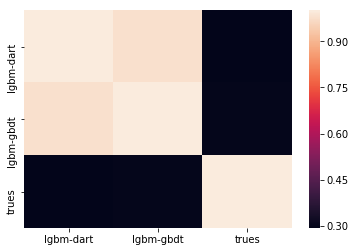

In [8]:
sns.heatmap(corrs)

## 2nd level models validation: Simple holdout scheme
We have models predictions for months 31, 32, 33 and 34. 34 is the test set.

2nd level models will be fitted in 31 and 32 and validated in 33. After that, predictions are generated for month 34.

In [9]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

ridge_params = []
for alpha in [0.001, 0.01, 0.1, 0.3, 1.0, 2.0, 3.0, 5.0, 10.0, 30.0, 100.0]:
    for normalize in [False, True]:
        ridge_params.append({'alpha': alpha, 'normalize': normalize})


def find_best_params(model, params):
    best_score = 9999.
    best_params = None
    for p in params:
        meta_model = model(**p)
        train = preds_df[preds_df.date_block_num < 33]
        train_x = train[files]
        train_y = train['trues']
        meta_model.fit(train_x, train_y)
        # Validation
        val = preds_df[preds_df.date_block_num == 33]
        val_x = val[files]
        val_y = val['trues']
        preds = meta_model.predict(val_x)
        score = utils.compute_score(preds, val_y)
        if score < best_score:
            best_score = score
            best_params = p
            
    return best_score, best_params

best_score, best_ridge = find_best_params(Ridge, ridge_params)        
print('Best Score: %.4f' % best_score)
print(best_ridge)

et_params = []
for md in [1, 2, 3, 5, None]:
    et_params.append({'max_depth': md})
    
best_score, best_et = find_best_params(DecisionTreeRegressor, et_params)        
print('Best Score: %.4f' % best_score)
print(best_et)

Best Score: 0.8970
{'alpha': 2.0, 'normalize': True}
Best Score: 0.9485
{'max_depth': 5}


In [10]:
# Predict test
meta_model = Ridge(**best_ridge)
train = preds_df[preds_df.date_block_num < 34]
x = train[files]
y = train['trues']
meta_model.fit(x, y)
dict(zip(x.columns, meta_model.coef_))

{'lgbm-dart': 0.50211351439744978, 'lgbm-gbdt': 0.48008028815714054}

In [11]:
test_df = preds_df[preds_df.date_block_num == 34]
test_x = test_df[files]
submit = test_df[['shop_id', 'item_id']]
submit['item_cnt_month'] = meta_model.predict(test_x)
submit = submit.merge(test_preds, on=['shop_id', 'item_id'])
submit = submit.sort_values('ID')
submit.head()

,shop_id,item_id,item_cnt_month,ID
0,5,5037,0.678605,0
1,5,5320,0.536872,1
2,5,5233,1.033096,2
3,5,5232,0.697581,3
4,5,5268,2.073911,4


In [12]:
assert len(submit) == 214200

In [13]:
submit = submit.set_index('ID')['item_cnt_month']
submit.to_frame().to_csv('ensemble.csv', index_label='ID')